# Postavitev preprostega agentnega modela: 2. Del
V spodnjem postopku bomo nekoliko nadgradili model iz prejšnjega dela. Namesto da bomo imeli samo dva ponudnika, bomo uvedli vrednost izbire, s katero bomo spremljali ali so agenti bolj naklonjeni pozitivni ali negativni strani.

### Zgradba agenta

Tako kot v prejšnem modelu bomo pripravili seznama za lastnosti agentov in funkcijo za izdelavo agentov.

<img src="img/zgradbaagenta2.jpg" width="600"/>

In [117]:
vrednost_izbire = [-1.,1.] #začetna vrednost izbire
osebnosti = ['trmast','prilagodljiv']

In [118]:
def ustvari_agenta(vrednost_izbire, osebnosti):
    return [vrednost_izbire, osebnosti]

### Naključna vrednost

Agentom bomo prilagodili vrednost izbire tako, da ji bomo dodali naključno vrednost normalne porazdelitve. Za center normalne porazdelitve bomo uporabili začetno vrednost izibre agenta.
<img src="img/porazdelitev.png" width="400"/>

In [119]:
from copy import deepcopy 
from numpy.random import normal
from numpy.random import gumbel
import numpy

def vrsta_distribucije(agent):
    distribucija_agenta = normal(agent[0],0.2) #dodamo gaussovo porazdelitev s centrom in standardnim odklonom 0,2
    return distribucija_agenta

#preizkusimo če deluje
testni_agent1 = [-1,'trmast']
testni_agent2 = [1,'prilagodljiv']
testni_agent1[0] = vrsta_distribucije(testni_agent1)
testni_agent2[0] = vrsta_distribucije(testni_agent2)
print(testni_agent1)
print(testni_agent2)

[-0.5197918038271974, 'trmast']
[1.0930946642018127, 'prilagodljiv']


### Logika odločanja

V naslednjem koraku bomo v model dodali logiko odločanja, oziroma funkcijo, s katero bo agent pridobival znanje od drugih agentov. Agent se bo znanju prilagajal glede na njegovo osebnost. 
1. Prilagodljivi agenti se bodo agentu s katerim komunicirajo približali za polovico razdalje med njunima vrednostima izbire.
2. Trmast agent ne bo popolnoma trmast ampak se bo prav tako rahlo prilagajal. Njegova vrednost izbire se bo za eno desetino razdalje približala agentu s katerim komunicira.

<img src="img/odlocitvenalogika2.jpg" width="600"/>

In [120]:
def pridobiti_znanje(distribucija,agent):
    nova_izbira = 0
    #if random.random() <= 0.2:
    if agent[1] == "prilagodljiv": #pogoj če je agent prilagodljiv
        nova_izbira = (agent[0] + distribucija) / 2.
    else: #pogoj ki se izvede ko je agent trmast
        razlika = abs(distribucija-agent[0])
        if distribucija > agent[0]:
            nova_izbira = agent[0] + (razlika/10.)
        else:
            novo_izbira = agent[0] - (razlika/10.)
    agent[0] = deepcopy(nova_izbira)

Logiko še testiramo, da vidimo če deluje pravilno:
<img src="img/testlogike.jpg" width="600"/>

In [121]:
trmast_agent = [-1,'trmast']
prilagodljiv_agent = [-1,'prilagodljiv']

pridobiti_znanje(1, trmast_agent)
pridobiti_znanje(1, prilagodljiv_agent)

print("Prilagodljiv agent", prilagodljiv_agent)
print("Trmast agent", trmast_agent)

Prilagodljiv agent [0.0, 'prilagodljiv']
Trmast agent [-0.8, 'trmast']


### Komunikacija
Z naslednjo funkcijo bomo opisali komunikacijo med dvema agentoma. Funkcija naprej pokliče funkcijo, ki agentu določi vrednost iz distribucijo, nato pa fukncijo za pridobivanje znanja, ki agentoma prilagodi vrednost izbire. 

In [122]:
def pogovor(agent1,agent2):
    #najprej pridobimo vrednosti distribuceja za vsakega agenta
    agent1_distribucija = vrsta_distribucije(agent1)
    agent2_distribucija = vrsta_distribucije(agent2)
    #med agentoma prenesemo znanje
    pridobiti_znanje(agent2_distribucija,agent1)
    pridobiti_znanje(agent1_distribucija,agent2)
    
    return agent1_distribucija, agent2_distribucija, agent1, agent2


Če testiramo komunikacijo na prejšnih dveh agentih lahko opazujemo kako se jima spremeni vrednost izbire. 

In [123]:
pogovor(trmast_agent,prilagodljiv_agent)
print("Prilagodljiv agent", prilagodljiv_agent)
print("Trmast agent", trmast_agent)

Prilagodljiv agent [-0.3534478080280055, 'prilagodljiv']
Trmast agent [-0.7087395356342091, 'trmast']


### Simulacija
Pri simulaciji bomo najprej ustvarili funkcijo, ki nam ustvari večje število agentov. Funkcija bo poskrbela da se osebnosti in vrednosti izbire agentom določajo naključno, tako da dobimo množico agentov, ki se med seboj razlikujejo 

In [124]:
import random
def ustvari_populacijo(st_agentov):
    populacija = []
    
    for i in range(st_agentov):
        m = random.randint(0,1)
        p = random.randint(0,1)
        agent = ustvari_agenta(vrednost_izbire[m], osebnosti[p])
        #agenta dodamo v seznam populacija
        populacija.append(agent)

    return populacija

Testiramo funkcijo za izdelavo populacije agentov:

In [125]:
ustvari_populacijo(10)

[[-1.0, 'trmast'],
 [1.0, 'trmast'],
 [-1.0, 'trmast'],
 [-1.0, 'prilagodljiv'],
 [1.0, 'prilagodljiv'],
 [-1.0, 'prilagodljiv'],
 [-1.0, 'trmast'],
 [-1.0, 'trmast'],
 [1.0, 'prilagodljiv'],
 [1.0, 'prilagodljiv']]

Zaenkrat lahko samo ustvarimo veliko populacijo agentov. Agente moramo pripeljati do tega, da se srečajo in izvedejo interakcijo. Da bodo ta srečanja naključna bomo ustvarili naslednjo funkcijo, ki bo iz celotne populacije agentov naključno izbirala pare agentov. 

In [126]:
from numpy.random import choice

def izberi_par(populacija):
    i = random.randint(0, len(populacija) - 1) 
    j = random.randint(0, len(populacija) - 1)
    
    while i == j:
        j = random.randint(0, len(populacija) - 1)
        
    return populacija[i], populacija[j]

Ko uredimo srečanja agentov se lahko lotimo simulacije večjega števila agentov. V ta namen bomo ustvarili naslednjo funkcijo, s katero pokličemo prej ustvarjeni funkciji za izdelavo množice agentov in izbiro parov agentov. Dunkciji bomo dodali tudi argument s katerim bomo funkciji sporočili kolikokrat naj se izvede. V namen prikaza ki sledi bomo s funkcijo tudi shranili seznam začetne populacije.

In [127]:
def simulacija(stevilo_agentov, stevilo_simulacij):
    
    zacetna_populacija = ustvari_populacijo(stevilo_agentov)
    populacija=deepcopy(zacetna_populacija)
    
    for i in range(stevilo_simulacij):
        
        par_agentov = izberi_par(populacija)
        #print(par_agentov[0],par_agentov[1])
        pogovor(par_agentov[0],par_agentov[1])
    
    return zacetna_populacija, populacija

Z naslednjo vrstico bomo pognali simulacijo in ustvarili spremenljivki, ki vsebujeta seznama populacije agentov pred začetkom simulacije in seznam agentov po koncu simulacije.

In [128]:
populacija_zacetek, populacija_konec = simulacija(100,2000)

In [129]:
for i in range(5):
    print("Zacetek",populacija_zacetek[i])
for i in range(5):
    print("Konec", populacija_konec[i])

Zacetek [-1.0, 'trmast']
Zacetek [1.0, 'prilagodljiv']
Zacetek [1.0, 'prilagodljiv']
Zacetek [-1.0, 'trmast']
Zacetek [1.0, 'prilagodljiv']
Konec [0, 'trmast']
Konec [0.10329465054721673, 'prilagodljiv']
Konec [0.05242021640433611, 'prilagodljiv']
Konec [0, 'trmast']
Konec [-0.175483032504271, 'prilagodljiv']


Na koncu bomo prikazali histogram, ki prikazuje razporeditev vrednosti izbire pred in po simulaciji.

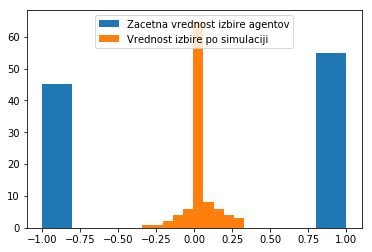

In [130]:
%matplotlib inline 
import matplotlib.pyplot as plt
#import seaborn as sns 

zacetna_izbira = []
koncna_izbira = []

for agent in range(len(populacija_zacetek)):
    zacetna_izbira.append(populacija_zacetek[agent][0])
    koncna_izbira.append(populacija_konec[agent][0])
    
plt.hist(zacetna_izbira, label='Zacetna vrednost izbire agentov')
plt.hist(koncna_izbira, label='Vrednost izbire po simulaciji')
plt.legend(loc='upper center')
plt.show()